[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alucantonio/data_enhanced_simulation/blob/master/7_IntroRL.ipynb)

# Introduction to Reinforcement Learning

References:
- Zai & Brown's "Deep Reinforcement Learning in Action"
- Thomas Simonini's [course](https://huggingface.co/learn/deep-rl-course/en/unit0/introduction)
- David Silver's RL [course](https://www.davidsilver.uk/teaching/)

Reinforcement Learning (RL) is a branch of machine learning. The idea behind RL is that
an **agent** (an AI) will learn from the **environment** by interacting with it (through
trial and error) and receiving **rewards** (negative or positive) as feedback for
performing actions. RL is a framework for solving control tasks (also called **decision
problems**). 

Let's look at the definition of the key terms.

A **reward** $R_t$ is a scalar feedback signal that indicates how well agent is doing at step $t$
- The agent’s job is to maximise cumulative reward
- Actions may have long term consequences
- It may be better to sacrifice immediate reward to gain more long-term reward

RL is based on the _reward hypothesis_: All goals can be described by the maximisation of expected
cumulative reward.

A **state** is the set of information available in the environment that can be
used to make decisions.
- **Markov decision process (MDP)**: the current state alone contains enough information to
choose optimal actions to maximize future rewards (we can forget the history of state-actions).

A **policy** characterizes the agent's behavior in some environment. It is a map between
states and actions (can be a probability distribution). The probability of each action in the distribution is
the probability that the action will produce the greatest reward. 
The _optimal policy_ is the strategy that maximizes the rewards.

The **value** function gives a prediction of future reward. It maps a state or a
state-action pair into the expected reward (long-term average of
rewards received after being in some state or taking some action). When we speak of
_the_ value function, we usually mean a state-value function. The value function depends
on the policy used to take actions. 

Examples of problems solvable via RL:
- Fly stunt manoeuvres in a helicopter
- Defeat the world champion at Backgammon
- Manage an investment portfolio
- Control a power station
- Make a humanoid robot walk
- Play many diﬀerent Atari games better than humans


RL algorithm can, in principle, employ any statistical learning model, but it has become
increasingly popular and effective to use deep neural networks.

## Solving the multi-arm bandit

Consider $n$ slot machines, each having 1 lever. We call this situation an $n$-armed
bandit. We have $n$ possible actions (here $n = 10$) where an action means pulling the
arm, or lever, of a particular slot machine, and at each play ($k$) of this game we can
choose a single lever to pull. After taking an action ($a$) we will receive a reward,
$R_k$ (reward at play $k$). Each lever has a unique probability distribution of 
payouts (rewards).

We implement our reward probability distributions for each arm in the following way: 
Each arm will have a probability, e.g., 0.7, and the maximum reward is $10.
We will set up a for loop going to 10, and at each step it will add 1 to the reward if a
random float is less than the arm’s probability.

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

In [17]:
def get_reward(prob, n=10):
    reward = 0;
    for i in range(n):
        if random.random() < prob:
            reward += 1
    return reward

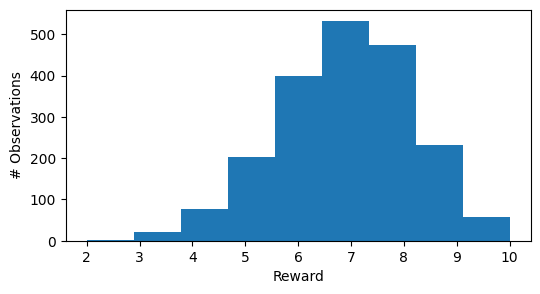

In [18]:
# reward distribution for a 10-armed bandit with probability 0.7
reward_test = [get_reward(0.7) for _ in range(2000)]

plt.figure(figsize=(6,3))
plt.xlabel("Reward")
plt.ylabel("# Observations")
plt.hist(reward_test,bins=9)
plt.show()

Our strategy should be to play a few times, choosing different levers and observing
our rewards for each action. Then we want to only choose the lever with the largest
observed average reward.

- **Action-value function** $Q_k(a)$: gives the value of the action $a$ at play $k$ as the
arithmetic mean of all previous rewards received for taking action $a$ (**expected
reward**).

This method of simply choosing the best lever that we know of so far
is called a **greedy** (or exploitation) method. We need some **exploration** 
of other levers (other slot machines) to discover the true best action.

We can use an **(epsilon)-greedy** strategy, such that with a probability, epsilon, 
we will choose an action, a, and the rest of the time we will choose the best lever
(maximizes action-value function).

In [19]:
def update_record(record,action,r):
    # compute new average reward
    new_r = (record[action,0] * record[action,1] + r) / (record[action,0] + 1)
    record[action,0] += 1
    record[action,1] = new_r
    return record

In [20]:
def get_best_arm(record):
    arm_index = np.argmax(record[:,1],axis=0)
    return arm_index

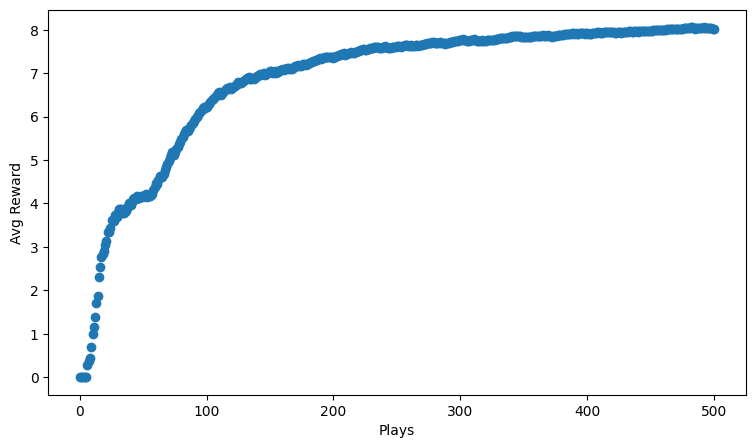

In [21]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
fig.set_size_inches(9,5)

n = 10
eps = 0.2 # epsilon parameter
probs = np.random.rand(n) # bandit probabilities

# for each arm store the number of times pulled (column 0) and the average reward
# (column 1)
record = np.zeros((n,2)) 

rewards = [0]
# play games
for i in range(500):
    # epsilon-greedy strategy
    if random.random() > eps:
        choice = get_best_arm(record)
    else:
        choice = np.random.randint(n)

    r = get_reward(probs[choice])
    record = update_record(record,choice,r)
    mean_reward = ((i+1) * rewards[-1] + r)/(i+2)
    rewards.append(mean_reward)

ax.scatter(np.arange(len(rewards)),rewards)
plt.show()

Instead of the $\epsilon$-greedy strategy, we can use a _softmax_ selection policy to avoid choosing the worst action, but still keeping some ability
to explore to find the best one (we don't need `get_best_arm`).

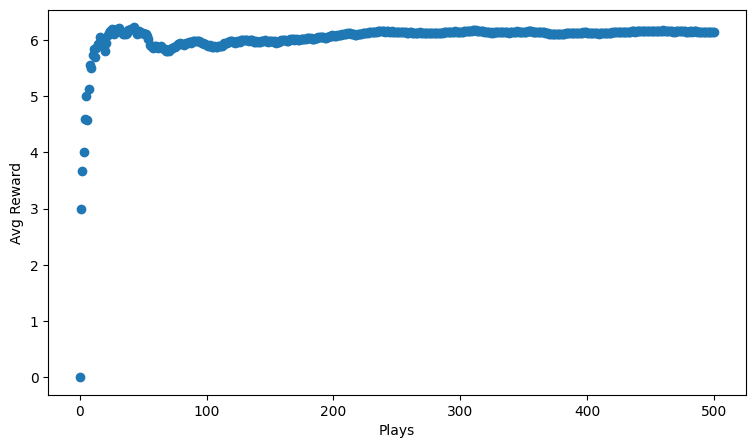

In [22]:
def softmax(av, tau=1.12):
    # takes the action-value vector (av) as input; tau controls the "temperature"
    softm = (np.exp(av / tau) / np.sum(np.exp(av / tau)))
    return softm

probs = np.random.rand(n)
record = np.zeros((n,2))
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
fig.set_size_inches(9,5)
rewards = [0]
for i in range(500):
    p = softmax(record[:,1],tau=0.7)
    choice = np.random.choice(np.arange(n),p=p)
    r = get_reward(probs[choice])
    record = update_record(record,choice,r)
    mean_reward = ((i+1) * rewards[-1] + r)/(i+2)
    rewards.append(mean_reward)

ax.scatter(np.arange(len(rewards)),rewards)
plt.show()

## Exercise: introducing state (contextual bandits)

In the _contextual bandit_ problem, there is a different reward distribution over the
actions for each state.  For simplicity, the number of states equals
the number of arms, but in general the state space is often much larger than the
action space. Here, we have $n$ different reward distributions
over actions for each of $n$ states. 

Instead of storing the rewards for each state-action pair, we use a neural
network to learn the relation between state-action and reward.

In [4]:
from jax import random, vmap
import numpy as np
from flax import nnx
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [15]:
# Auxiliary functions
def softmax(av, tau=1.12):
    # takes the action-value vector (av) as input; tau controls the "temperature"
    softm = (jnp.exp(av / tau) / jnp.sum(jnp.exp(av / tau)))
    return softm

def one_hot(N, pos, val=1):
    one_hot_vec = jnp.zeros(N)
    one_hot_vec = one_hot_vec.at[pos].set(val)
    return one_hot_vec

def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

1. Complete the implementation of the `ContextBandit` environment.

In [12]:
class ContextBandit:
    def __init__(self, seed=42, arms=10):
        key = random.key(seed)
        self.arms = arms
        self.init_distribution(key, arms)
        
    def init_distribution(self, key, arms):
        # Num states = Num Arms to keep things simple
        # each row represents a state, each column an arm
        self.bandit_matrix = random.uniform(key, shape=(arms,arms))

    def reward(self, prob, key):
        subkeys = random.split(key, self.arms + 1)
        key = subkeys[0]

        # Compute the reward by "collecting" payouts from all arms
        reward = 0.

        return reward, key 

    def update_state(self, key):
        key, subkey = random.split(key)
        # return state randomly sampled from uniform distribution
        # state = ... 
        return state, key
        
    def get_reward(self,arm,state,key):
        # Get the reward associated from choosing a certain arm from the given state
        # (based on the bandit_matrix distribution)
        # ...
        pass
        
    def choose_arm(self, arm, state, key):
        # Get the reward and update the state
        # ...
        # ...
        return reward, state, key

In [ ]:
#@title Solution:

class ContextBandit:
    def __init__(self, seed=42, arms=10):
        key = random.key(seed)
        self.arms = arms
        self.init_distribution(key, arms)
        
    def init_distribution(self, key, arms):
        # Num states = Num Arms to keep things simple
        # each row represents a state, each column an arm
        self.bandit_matrix = random.uniform(key, shape=(arms,arms))

    def reward(self, prob, key):
        subkeys = random.split(key, self.arms + 1)
        key = subkeys[0]  # Update key for future calls

        # Use vmap to apply random.uniform with each subkey
        rewards = vmap(lambda k: random.uniform(k) < prob)(subkeys[1:])
        
        return rewards.sum(), key 

    def update_state(self, key):
        # return state randomly sampled from uniform distribution
        key, subkey = random.split(key)
        state = random.randint(subkey, shape=(), minval=0, maxval=self.arms)
        return state, key
        
    def get_reward(self,arm,state,key):
        return self.reward(self.bandit_matrix[state,arm], key)
        
    def choose_arm(self, arm, state, key):
        reward, key = self.get_reward(arm, state, key)
        state, key = self.update_state(key)
        return reward, state, key

In [13]:
arms = 10
N, D_in, H, D_out = 1, arms, 100, arms
env = ContextBandit(arms)

2. Create a NN model that takes as input a one-hot encoded vector of the state and
   returns the values (rewards) associated to choosing each arm from that state.

In [14]:
class Model(nnx.Module):
  def __init__(self, D_in, D_out, rngs: nnx.Rngs):
    pass

  def __call__(self, x):
    pass


In [ ]:
#@title Solution:

class Model(nnx.Module):
  def __init__(self, D_in, D_out, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(D_in, H, rngs=rngs)
    self.linear2 = nnx.Linear(H, D_out, rngs=rngs)

  def __call__(self, x):
    y = nnx.relu(self.linear1(x))
    y = nnx.relu(self.linear2(y))
    return y


3. Define the training loop for the NN model, where at each epoch an action is chosen _probabilistically_
   based on the predicted rewards from the model and the model weights are updated based
   on the _actual_ reward obtained by taking that action.

In [17]:
#@title Solution:

@nnx.jit
def _train_epoch(model, optimizer, cur_state, key):
    # one-hot encoding of the current state
    oh_cur_state = one_hot(arms, cur_state)

    def loss(model, cur_state, key):
        # predict rewards for each action
        y_pred = model(oh_cur_state)

        # convert rewards to probability distribution
        av_softmax = softmax(y_pred, tau=2.0)

        # choose new action probabilistically
        key, subkey = random.split(key)
        choice = random.choice(key=subkey, a=arms, p=av_softmax)
        cur_reward, cur_state, key = env.choose_arm(choice, cur_state, key)

        # update one_hot_reward to use it as labeled training data
        reward = y_pred.at[choice].set(cur_reward)
        return optax.losses.squared_error(y_pred, reward).mean(), (cur_reward, cur_state, key)

    # update network weights based on MSE between predicted and actual rewards 
    grads, res = nnx.grad(loss, has_aux=True)(model, cur_state, key)
    optimizer.update(grads)

    return res

def train(env, model, optimizer, epochs=5000):
    # initialize random state
    key = random.key(6)
    cur_state, key = env.update_state(key)

    rewards = []

    for _ in range(epochs):

        cur_reward, cur_state, key = _train_epoch(model, optimizer, cur_state, key)

        rewards.append(cur_reward)

    return np.array(rewards)

4. Train the model for 5000 epochs and plot the running mean (use the auxiliary function
   defined above) of the rewards.

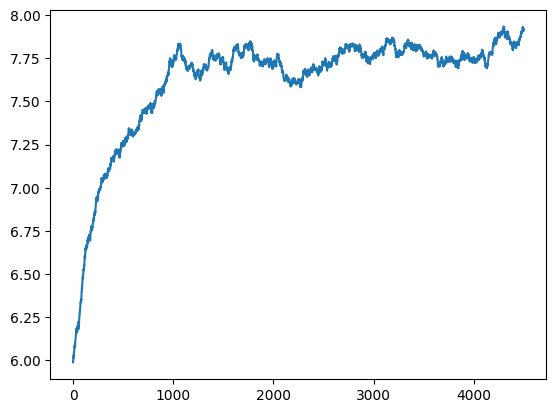

In [18]:
#@title Solution:

model = Model(D_in, D_out, rngs=nnx.Rngs(0))

lr = 0.01 # learning rate
optimizer = nnx.Optimizer(model, optax.adam(lr))

rewards = train(env, model, optimizer)
plt.plot(running_mean(rewards,N=500))
plt.show()